Connect to Drive


---



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/AN2DL_HW1

/gdrive/My Drive/AN2DL_HW1


# **Libraries** 

In [3]:
import tensorflow as tf

import os
import time 

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Download and import splitfolders library
!pip install split-folders
import splitfolders

# Download and import visualkeras library
!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

     |████████████████████████████████| 795 kB 5.3 MB/s 
2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load the **Dataset**

In [5]:
# Load the dataset to be used for classification
if not os.path.exists('data'):
  !unzip data.zip
if not os.path.exists('dataset'):
  splitfolders.ratio('data/', output='dataset', seed=seed, ratio=(.8, .2),)

Streaming output truncated to the last 5000 lines.
  inflating: data/Tomato/37979.jpg   
  inflating: data/Tomato/37980.jpg   
  inflating: data/Tomato/37982.jpg   
  inflating: data/Tomato/37983.jpg   
  inflating: data/Tomato/37984.jpg   
  inflating: data/Tomato/37985.jpg   
  inflating: data/Tomato/37988.jpg   
  inflating: data/Tomato/37989.jpg   
  inflating: data/Tomato/37990.jpg   
  inflating: data/Tomato/37992.jpg   
  inflating: data/Tomato/37993.jpg   
  inflating: data/Tomato/37994.jpg   
  inflating: data/Tomato/37995.jpg   
  inflating: data/Tomato/37996.jpg   
  inflating: data/Tomato/37997.jpg   
  inflating: data/Tomato/37998.jpg   
  inflating: data/Tomato/37999.jpg   
  inflating: data/Tomato/38000.jpg   
  inflating: data/Tomato/38001.jpg   
  inflating: data/Tomato/38003.jpg   
  inflating: data/Tomato/38004.jpg   
  inflating: data/Tomato/38005.jpg   
  inflating: data/Tomato/38006.jpg   
  inflating: data/Tomato/38007.jpg   
  inflating: data/Tomato/38008.jpg   

Copying files: 17728 files [03:55, 75.31 files/s]


In [6]:
# Dataset folders 

dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

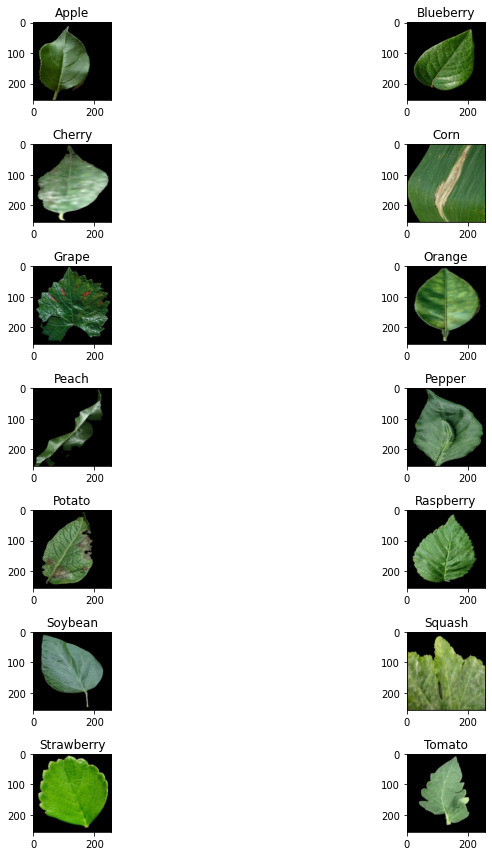

In [7]:
#optional
# Plot example images from dataset
 
labels = ['Apple',              # 0
          'Blueberry',          # 1
          'Cherry',             # 2
          'Corn',               # 3
          'Grape',              # 4
          'Orange',             # 5
          'Peach',              # 6
          'Pepper',             # 7
          'Potato',             # 8
          'Raspberry',          # 9
          'Soybean',            # 10
          'Squash',             # 11
          'Strawberry',         # 12
          'Tomato']             # 13     


num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 14:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [9]:
# Inspect dataset structure on disk
print("Depth 0 (dataset)")
print("-------")
!ls dataset
print()
print("Depth 1 (e.g., dataset/train)")
print("------------------------")
!ls dataset/train
print()
print("Depth 2 (e.g., dataset/train/Apple)")
print("------------------------")
!ls dataset/train/Apple

Depth 0 (dataset)
-------
train  val

Depth 1 (e.g., dataset/train)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., dataset/train/Apple)
------------------------
00001.jpg  00183.jpg  00360.jpg  00533.jpg  22479.jpg  22658.jpg  22845.jpg
00003.jpg  00184.jpg  00361.jpg  00534.jpg  22480.jpg  22660.jpg  22847.jpg
00004.jpg  00185.jpg  00362.jpg  00535.jpg  22482.jpg  22664.jpg  22848.jpg
00006.jpg  00187.jpg  00363.jpg  00536.jpg  22483.jpg  22667.jpg  22849.jpg
00007.jpg  00188.jpg  00364.jpg  00537.jpg  22484.jpg  22671.jpg  22850.jpg
00009.jpg  00189.jpg  00365.jpg  00538.jpg  22487.jpg  22673.jpg  22851.jpg
00011.jpg  00192.jpg  00366.jpg  00539.jpg  22488.jpg  22676.jpg  22853.jpg
00012.jpg  00193.jpg  00367.jpg  00543.jpg  22490.jpg  22677.jpg  22854.jpg
00013.jpg  00194.jpg  00372.jpg  00544.jpg  22492.jpg  22679.jpg  22855.jpg
00015.jpg  00196.jpg  00374.jpg  00

# **Data Loader and Data Augmentation**

In [10]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='reflect',
                                    rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=True,
                                              seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


### Models metadata

In [11]:
input_shape = (256, 256, 3)
epochs = 200

#**CNN model**  

## build **CNN**

In [12]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    #Convolutions:
    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 =tfkl.MaxPool2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 =tfkl.MaxPool2D(
        pool_size = (2, 2)
    )(conv2)
 
    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 =tfkl.MaxPool2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 =tfkl.MaxPool2D(
        pool_size = (2, 2)
    )(conv4) 

    #Flattening
    flattening_layer = tfkl.Flatten(name='Flatten')(pool4)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    #Output
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

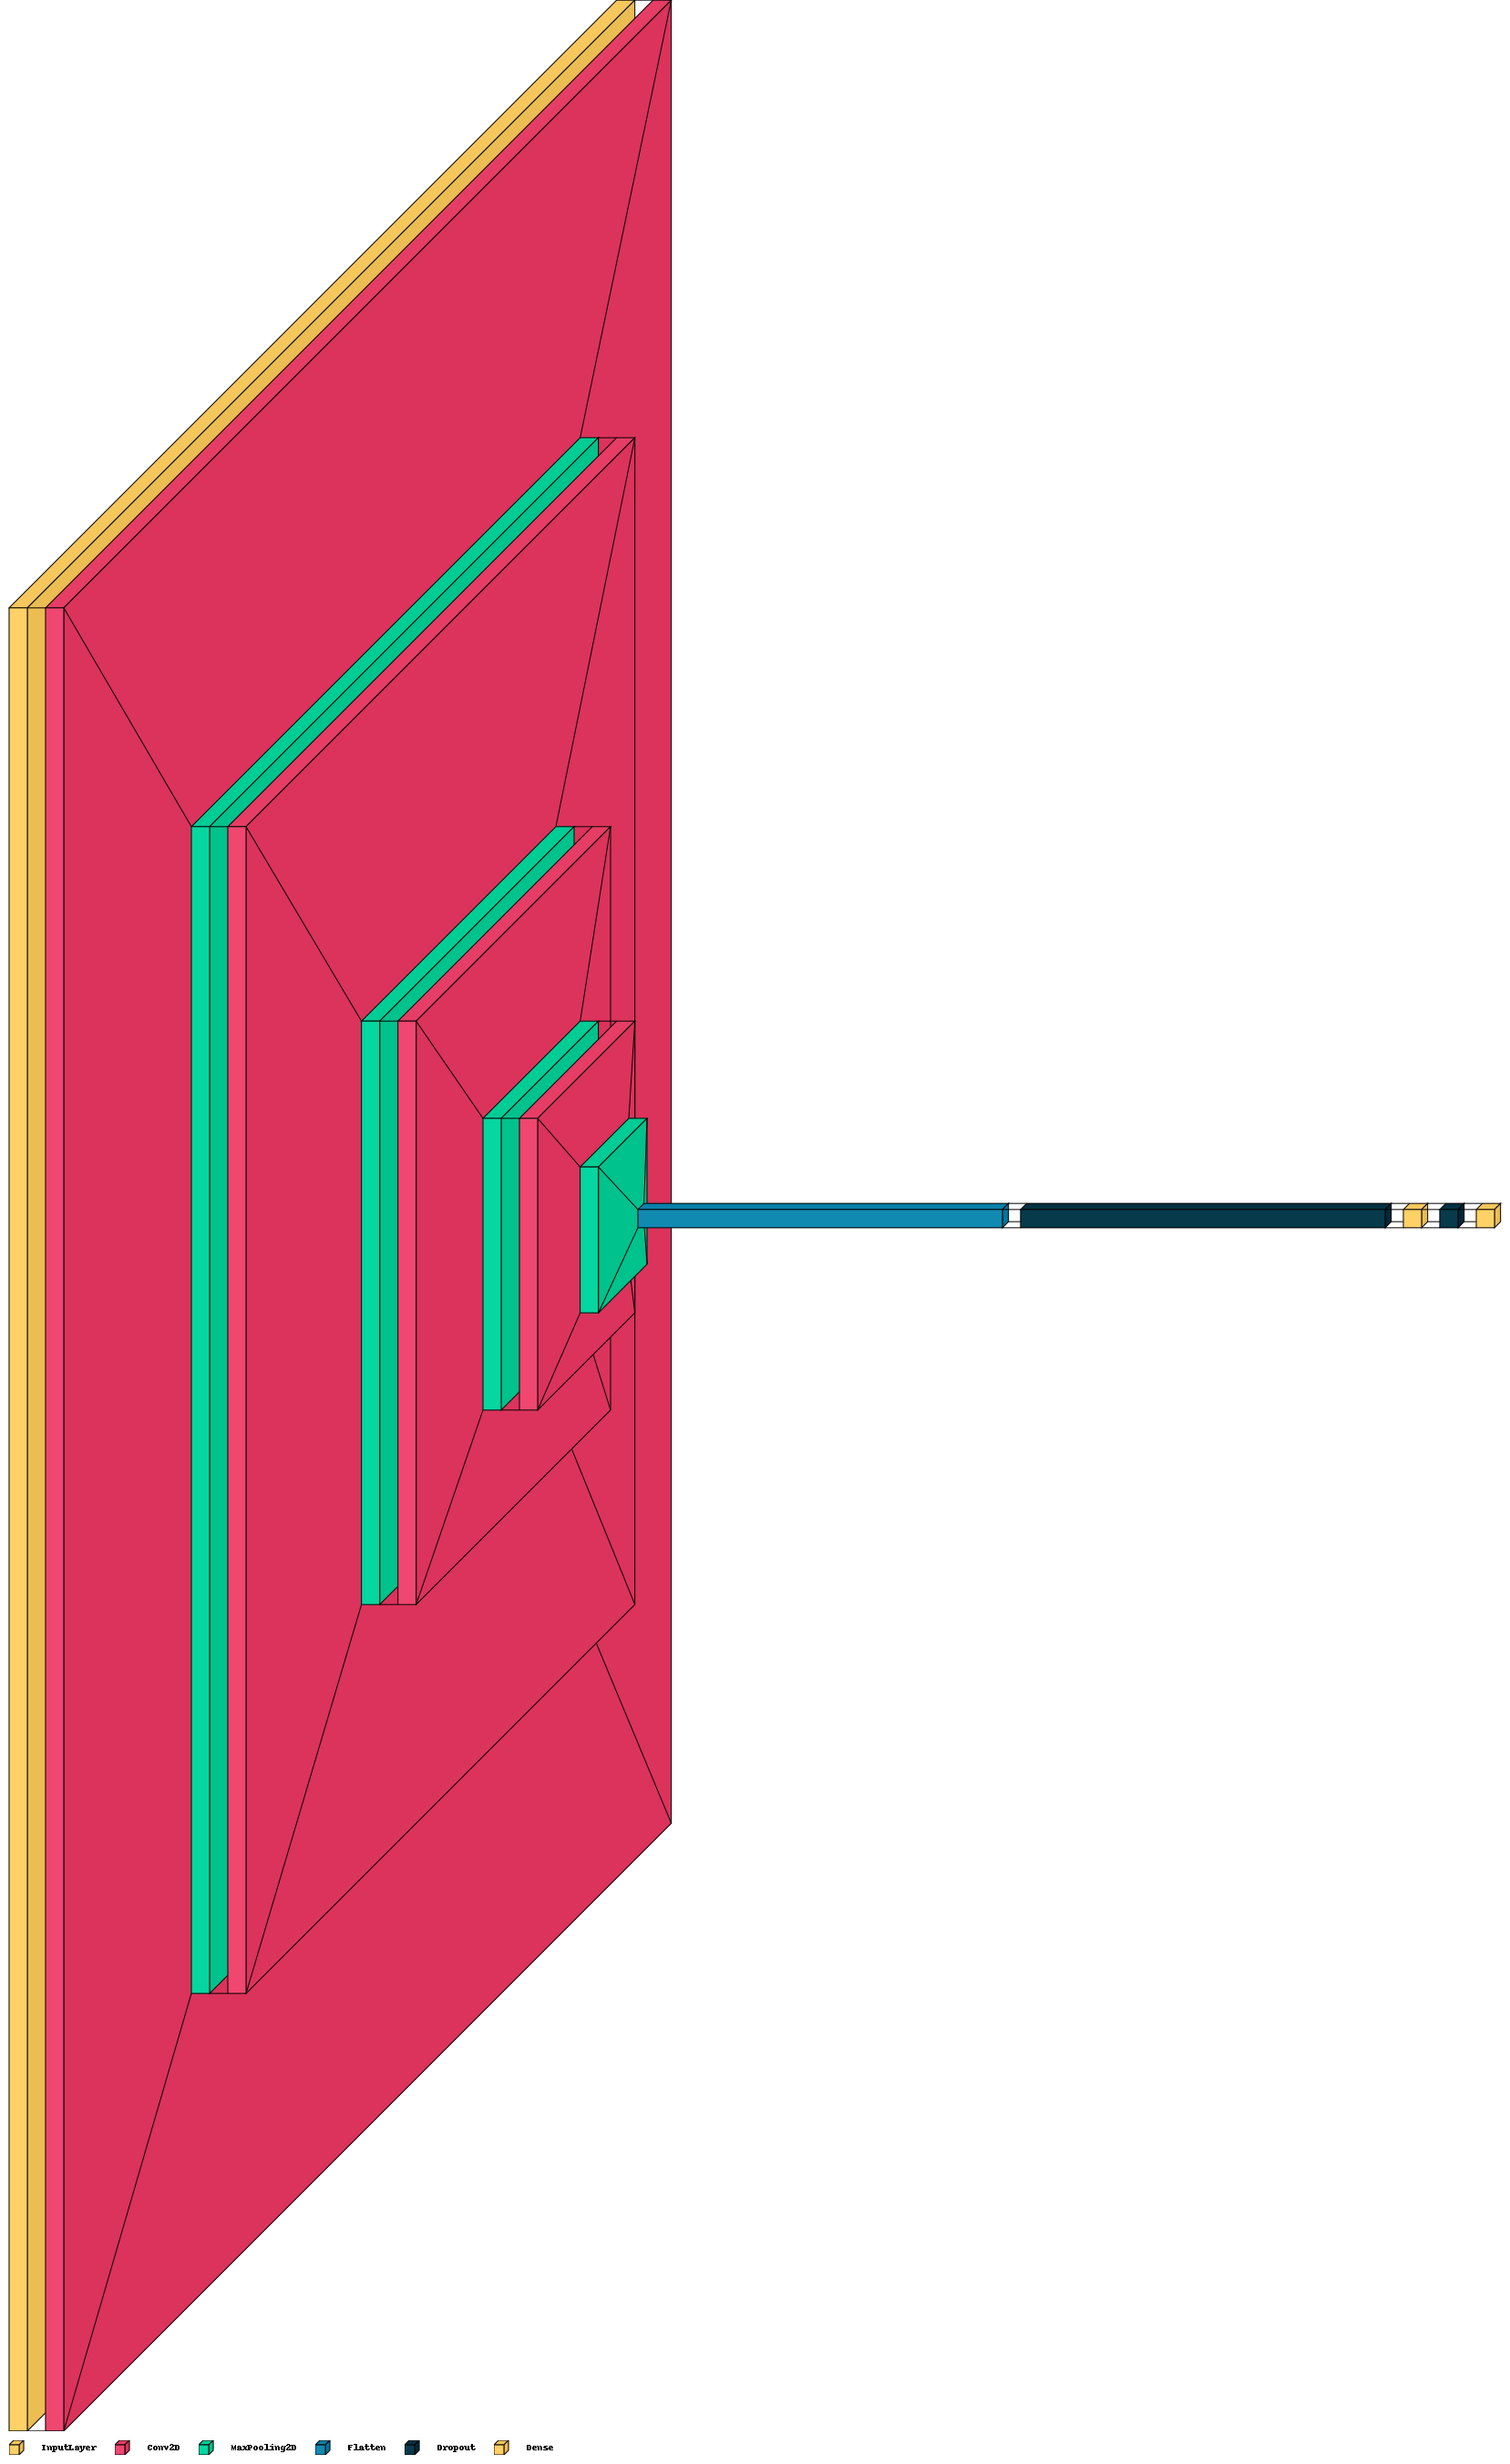

In [13]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

## train **CNN**

In [14]:
# Utility callbacks for training

callbacks = []

# Model checkpoint
# ----------------

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath='Submission/SubmissionModel/ckpt/hw1-OurCNN', save_weights_only=False, save_best_only=False) 
callbacks.append(ckpt_callback)

# Early Stopping
# --------------
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
callbacks.append(es_callback)

In [15]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks
).history

Epoch 1/200
1772/1772 [==============================] - ETA: 0s - loss: 1.8195 - accuracy: 0.4398

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 304s 166ms/step - loss: 1.8195 - accuracy: 0.4398 - val_loss: 1.2372 - val_accuracy: 0.6292
Epoch 2/200
1772/1772 [==============================] - ETA: 0s - loss: 1.2716 - accuracy: 0.5913

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 287s 162ms/step - loss: 1.2716 - accuracy: 0.5913 - val_loss: 1.0618 - val_accuracy: 0.6734
Epoch 3/200
1772/1772 [==============================] - ETA: 0s - loss: 1.0558 - accuracy: 0.6589

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 289s 163ms/step - loss: 1.0558 - accuracy: 0.6589 - val_loss: 0.7078 - val_accuracy: 0.7601
Epoch 4/200
1772/1772 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.7014

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 278s 157ms/step - loss: 0.9265 - accuracy: 0.7014 - val_loss: 0.6593 - val_accuracy: 0.7880
Epoch 5/200
1772/1772 [==============================] - ETA: 0s - loss: 0.8304 - accuracy: 0.7317

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 276s 156ms/step - loss: 0.8304 - accuracy: 0.7317 - val_loss: 0.5539 - val_accuracy: 0.8114
Epoch 6/200
1772/1772 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.7559

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 278s 157ms/step - loss: 0.7569 - accuracy: 0.7559 - val_loss: 0.4731 - val_accuracy: 0.8367
Epoch 7/200
1772/1772 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7742

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 282s 159ms/step - loss: 0.6977 - accuracy: 0.7742 - val_loss: 0.5371 - val_accuracy: 0.8212
Epoch 8/200
1772/1772 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7985

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 281s 158ms/step - loss: 0.6279 - accuracy: 0.7985 - val_loss: 0.3635 - val_accuracy: 0.8756
Epoch 9/200
1772/1772 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.8128

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 289s 163ms/step - loss: 0.5946 - accuracy: 0.8128 - val_loss: 0.4008 - val_accuracy: 0.8623
Epoch 10/200
1772/1772 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.8248

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 273s 154ms/step - loss: 0.5491 - accuracy: 0.8248 - val_loss: 0.3826 - val_accuracy: 0.8795
Epoch 11/200
1772/1772 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.8388

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 274s 155ms/step - loss: 0.5084 - accuracy: 0.8388 - val_loss: 0.2662 - val_accuracy: 0.9172
Epoch 12/200
1772/1772 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.8495

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 274s 155ms/step - loss: 0.4814 - accuracy: 0.8495 - val_loss: 0.2776 - val_accuracy: 0.9037
Epoch 13/200
1772/1772 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8548

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 279s 157ms/step - loss: 0.4697 - accuracy: 0.8548 - val_loss: 0.2638 - val_accuracy: 0.9144
Epoch 14/200
1772/1772 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8595

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 285s 161ms/step - loss: 0.4534 - accuracy: 0.8595 - val_loss: 0.2639 - val_accuracy: 0.9184
Epoch 15/200
1772/1772 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8718

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 285s 161ms/step - loss: 0.4105 - accuracy: 0.8718 - val_loss: 0.3012 - val_accuracy: 0.9178
Epoch 16/200
1772/1772 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8718

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 272s 154ms/step - loss: 0.4266 - accuracy: 0.8718 - val_loss: 0.3460 - val_accuracy: 0.8964
Epoch 17/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8773

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 266s 150ms/step - loss: 0.3978 - accuracy: 0.8773 - val_loss: 0.1885 - val_accuracy: 0.9341
Epoch 18/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8833

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 269s 152ms/step - loss: 0.3783 - accuracy: 0.8833 - val_loss: 0.2167 - val_accuracy: 0.9234
Epoch 19/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8851

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 268s 151ms/step - loss: 0.3736 - accuracy: 0.8851 - val_loss: 0.2382 - val_accuracy: 0.9324
Epoch 20/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.8897

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 273s 154ms/step - loss: 0.3572 - accuracy: 0.8897 - val_loss: 0.1949 - val_accuracy: 0.9381
Epoch 21/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8892

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 273s 154ms/step - loss: 0.3630 - accuracy: 0.8892 - val_loss: 0.2045 - val_accuracy: 0.9338
Epoch 22/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8913

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 280s 158ms/step - loss: 0.3534 - accuracy: 0.8913 - val_loss: 0.1965 - val_accuracy: 0.9398
Epoch 23/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8965

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 270s 152ms/step - loss: 0.3377 - accuracy: 0.8965 - val_loss: 0.1738 - val_accuracy: 0.9428
Epoch 24/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8989

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 265s 150ms/step - loss: 0.3348 - accuracy: 0.8989 - val_loss: 0.1639 - val_accuracy: 0.9457
Epoch 25/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.9026

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 268s 151ms/step - loss: 0.3193 - accuracy: 0.9026 - val_loss: 0.2301 - val_accuracy: 0.9302
Epoch 26/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8907

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 273s 154ms/step - loss: 0.3719 - accuracy: 0.8907 - val_loss: 0.1822 - val_accuracy: 0.9448
Epoch 27/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.9074

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 276s 156ms/step - loss: 0.3122 - accuracy: 0.9074 - val_loss: 0.1582 - val_accuracy: 0.9476
Epoch 28/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.9067

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 267s 150ms/step - loss: 0.3056 - accuracy: 0.9067 - val_loss: 0.3366 - val_accuracy: 0.9037
Epoch 29/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.9055

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 271s 153ms/step - loss: 0.3256 - accuracy: 0.9055 - val_loss: 0.1229 - val_accuracy: 0.9603
Epoch 30/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.9085

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 284s 160ms/step - loss: 0.2955 - accuracy: 0.9085 - val_loss: 0.1662 - val_accuracy: 0.9462
Epoch 31/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.9077

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 272s 153ms/step - loss: 0.3112 - accuracy: 0.9077 - val_loss: 0.1998 - val_accuracy: 0.9347
Epoch 32/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.9128

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 272s 154ms/step - loss: 0.2992 - accuracy: 0.9128 - val_loss: 0.1727 - val_accuracy: 0.9420
Epoch 33/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.9116

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 276s 156ms/step - loss: 0.2977 - accuracy: 0.9116 - val_loss: 0.1400 - val_accuracy: 0.9592
Epoch 34/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.9168

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 269s 152ms/step - loss: 0.2847 - accuracy: 0.9168 - val_loss: 0.1624 - val_accuracy: 0.9457
Epoch 35/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9145

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 269s 152ms/step - loss: 0.2821 - accuracy: 0.9145 - val_loss: 0.1804 - val_accuracy: 0.9448
Epoch 36/200
1772/1772 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.9072

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 279s 157ms/step - loss: 0.3078 - accuracy: 0.9072 - val_loss: 0.2263 - val_accuracy: 0.9361
Epoch 37/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.9144

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 276s 156ms/step - loss: 0.2872 - accuracy: 0.9144 - val_loss: 0.3041 - val_accuracy: 0.9169
Epoch 38/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.9150

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 280s 158ms/step - loss: 0.2936 - accuracy: 0.9150 - val_loss: 0.2284 - val_accuracy: 0.9352
Epoch 39/200
1772/1772 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9142

INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/ckpt/hw1-OurCNN/assets


1772/1772 [==============================] - 283s 160ms/step - loss: 0.2910 - accuracy: 0.9142 - val_loss: 0.1599 - val_accuracy: 0.9479


In [16]:
model.save("Submission/SubmissionModel/hw1-OurCNN")

INFO:tensorflow:Assets written to: Submission/SubmissionModel/hw1-OurCNN/assets


INFO:tensorflow:Assets written to: Submission/SubmissionModel/hw1-OurCNN/assets


In [ ]:
model = tfk.models.load_model('Submission/SubmissionModel/hw1-OurCNN')

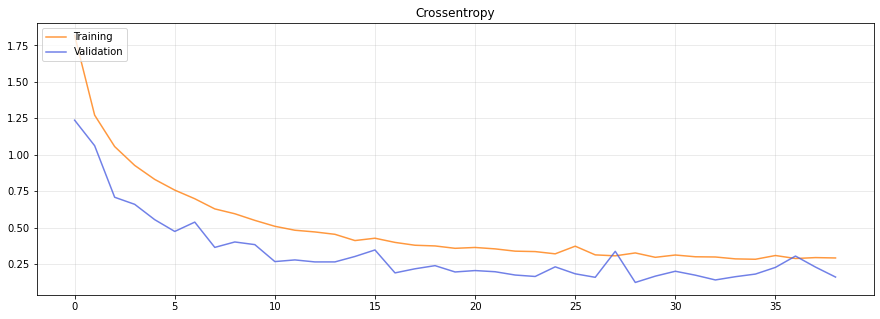

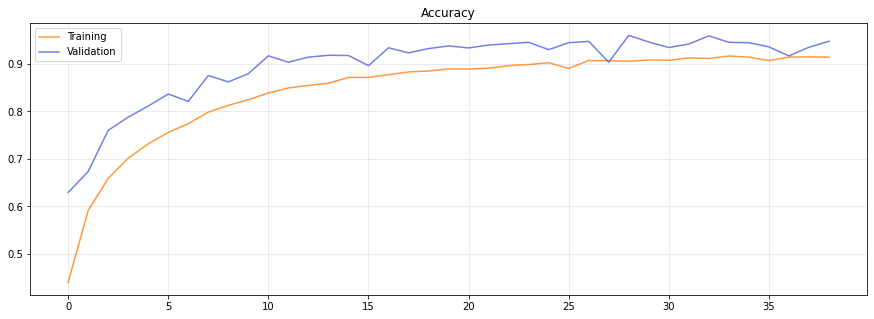

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()
plt.savefig('Training-Validation.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Accuracy: 0.9603
Precision: 0.9572
Recall: 0.9424
F1: 0.9488


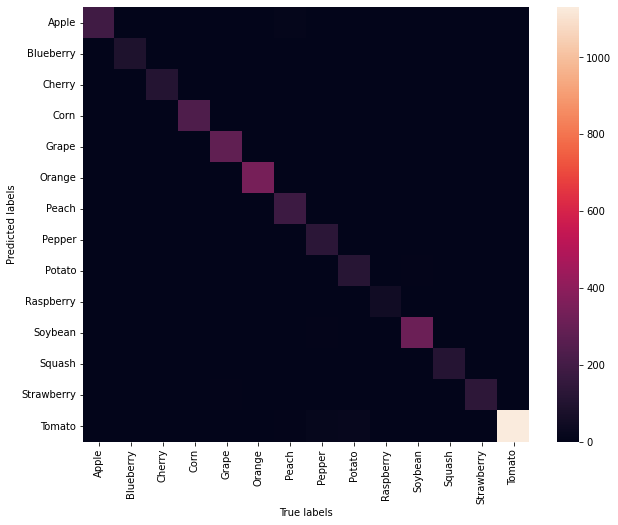

Classification Report
              precision    recall  f1-score   support

       Apple       0.92      0.98      0.95       198
   Blueberry       0.97      0.96      0.96        94
      Cherry       0.98      0.93      0.96       117
        Corn       1.00      0.96      0.98       242
       Grape       0.99      0.96      0.98       292
      Orange       0.99      0.97      0.98       350
       Peach       0.99      0.91      0.95       196
      Pepper       0.95      0.86      0.90       153
      Potato       0.93      0.82      0.87       144
   Raspberry       0.94      0.92      0.93        53
     Soybean       0.96      0.96      0.96       324
      Squash       0.96      0.98      0.97       115
  Strawberry       0.88      0.99      0.93       135
      Tomato       0.96      0.99      0.97      1139

    accuracy                           0.96      3552
   macro avg       0.96      0.94      0.95      3552
weighted avg       0.96      0.96      0.96      3552



In [18]:
# Compute the confusion matrix
predictions = model.predict_generator(generator=valid_gen)
predictions = np.argmax(predictions, axis=1)


cm = confusion_matrix(valid_gen.classes, predictions)
# Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, predictions)
precision = precision_score(valid_gen.classes, predictions, average='macro')
recall = recall_score(valid_gen.classes, predictions, average='macro')
f1 = f1_score(valid_gen.classes, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


#Print Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
print(classification_report(valid_gen.classes, predictions, target_names=target_names))